<a href="https://colab.research.google.com/github/alex-mat-s/Image-Quality-Analysis/blob/main/IQA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [29]:
from PIL import Image
import os
import pandas as pd
import matplotlib.pyplot as plt
import argparse
import torch
from torch import nn
from torchvision import models
import torch
from piq import BRISQUELoss, TVLoss
from torchvision import transforms
from tensorflow.keras.preprocessing.image import img_to_array
from scipy import stats
from beautifultable import BeautifulTable

In [22]:
def plot_images(df, both_scores=False, brisque_lst=None, tv_lst=None, nima_lst=None):
    """Plot images with scores"""
    fig, axes = plt.subplots(5, 4, figsize=(20,20), constrained_layout = True)
    for ind in range(df.shape[0]):
        axes[ind//4, ind%4].imshow(df.img.iloc[ind])
        axes[ind//4, ind%4].set_title(
            f'{df["names"].iloc[ind]} score: <{df["score"].iloc[ind]}>')
        if both_scores:
          axes[ind//4, ind%4].set_xlabel(
              f'BRISQUE: <{brisque_lst[ind]:.3f}>, TV: <{tv_lst[ind]:.3f}>, NIMA: <{nima_lst[ind]:.3f}>')

### Read Data

In [5]:
torch.cuda.is_available()

True

In [6]:
PATH = "/content/drive/MyDrive/ITMO/AMLT'23/Task #4"

In [13]:
# Get all file names
img_names = os.listdir(PATH+"/img/")
img_names = sorted(img_names)

# Read all images
img_lst = []
for filename in img_names:
    img_lst.append(Image.open(PATH+"/img/"+filename))

# Get scores
scores_df = pd.read_csv(PATH+"/scores", sep="\t", index_col=0)
scores_df["img"] = img_lst
scores_df["names"] = img_names

scores_df.head(5)

score                                                img     names
index                                                                    
0          5  <PIL.JpegImagePlugin.JpegImageFile image mode=...  0000.jpg
1          5  <PIL.JpegImagePlugin.JpegImageFile image mode=...  0001.jpg
2          2  <PIL.JpegImagePlugin.JpegImageFile image mode=...  0002.jpg
3          4  <PIL.JpegImagePlugin.JpegImageFile image mode=...  0003.jpg
4          4  <PIL.JpegImagePlugin.JpegImageFile image mode=...  0004.jpg

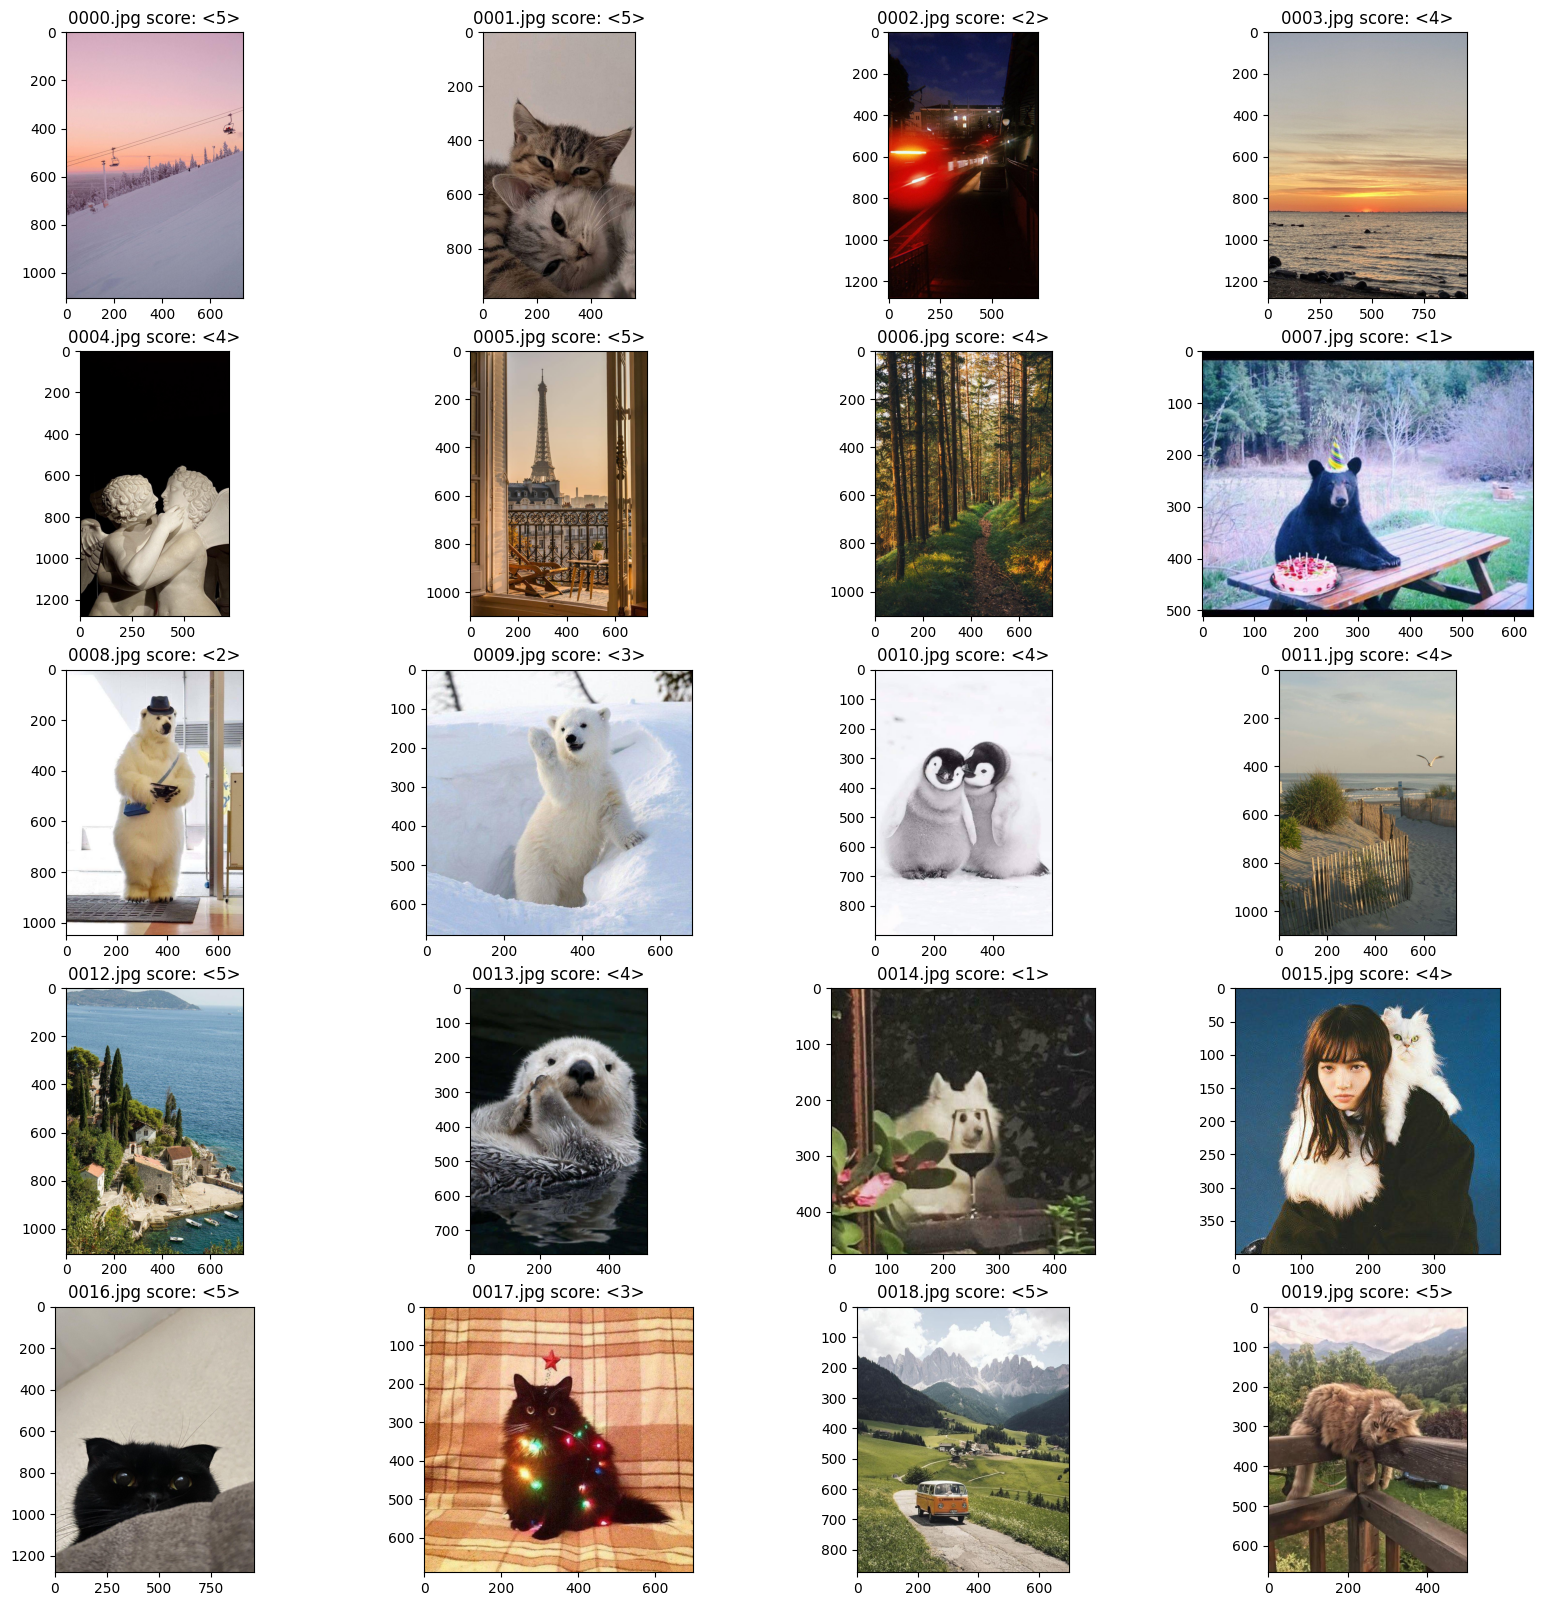

In [14]:
# Plot images
plot_images(scores_df)

### No-Reference image quality metrics

In [9]:
def rate(img_path):
    """
    Returns: Scores, mean, std
    """
    # Number of classes in the dataset
    num_classes = 10

    model_ft = models.densenet121(pretrained=True)
    num_ftrs = model_ft.classifier.in_features
    model_ft.classifier = nn.Sequential(
        nn.Linear(num_ftrs,num_classes),
        nn.Softmax(1)
    )

    # Weight Path
    weight_path = PATH + '/dense121_all.pt'

    # Load weights
    assert os.path.exists(weight_path)
    model_ft.load_state_dict(torch.load(weight_path))


    img = Image.open(img_path)
    transform = transforms.Compose([
            transforms.Resize(224),
            transforms.CenterCrop(224),
            transforms.ToTensor(),
        ])
    img = transform(img)

    with torch.no_grad():
        scores = model_ft(img.view(1,3,224,224))
        weighted_votes = torch.arange(10, dtype=torch.float) + 1
        mean = torch.matmul(scores, weighted_votes)
        std = torch.sqrt((scores * torch.pow((weighted_votes - mean.view(-1,1)), 2)).sum(dim=1))
    return scores.view(-1).numpy(), mean.item(), std.item()

def nima(img_path):
    scores, mean, std = rate(img_path)

    return mean

In [10]:
brisque = BRISQUELoss(data_range=1.)
tv = TVLoss()

In [11]:
tv_metrics = []
brisque_metrics = []
nima_metrics = []

for img, img_name in zip(scores_df.img, scores_df.names):

    img_arr = img_to_array(img)

    brisque_metrics.append(brisque(torch.tensor(img_arr).permute(2,0,1)[None, :,:,:]/255.).item())
    tv_metrics.append(tv(torch.tensor(img_arr).permute(2,0,1)[None, :,:,:]/255.).item())

    img_path = PATH + "/img/" + img_name
    nima_metrics.append(nima(img_path))

Downloading: "https://github.com/photosynthesis-team/piq/releases/download/v0.4.0/brisque_svm_weights.pt" to /root/.cache/torch/hub/checkpoints/brisque_svm_weights.pt
100%|██████████| 112k/112k [00:00<00:00, 37.6MB/s]
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth
100%|█████████

In [26]:
scores_df["BRISQUE"] = brisque_metrics
scores_df["TV"] = tv_metrics
scores_df["NIMA"] = nima_metrics

scores_df.head(5)

score                                                img     names  \
index                                                                       
0          5  <PIL.JpegImagePlugin.JpegImageFile image mode=...  0000.jpg   
1          5  <PIL.JpegImagePlugin.JpegImageFile image mode=...  0001.jpg   
2          2  <PIL.JpegImagePlugin.JpegImageFile image mode=...  0002.jpg   
3          4  <PIL.JpegImagePlugin.JpegImageFile image mode=...  0003.jpg   
4          4  <PIL.JpegImagePlugin.JpegImageFile image mode=...  0004.jpg   

         BRISQUE          TV      NIMA  
index                                   
0      39.435608   63.319496  5.421732  
1       7.740051   59.294865  5.414146  
2       9.649719   62.572384  5.423947  
3      13.645630  152.065491  5.399481  
4      20.724579   74.453674  5.431864

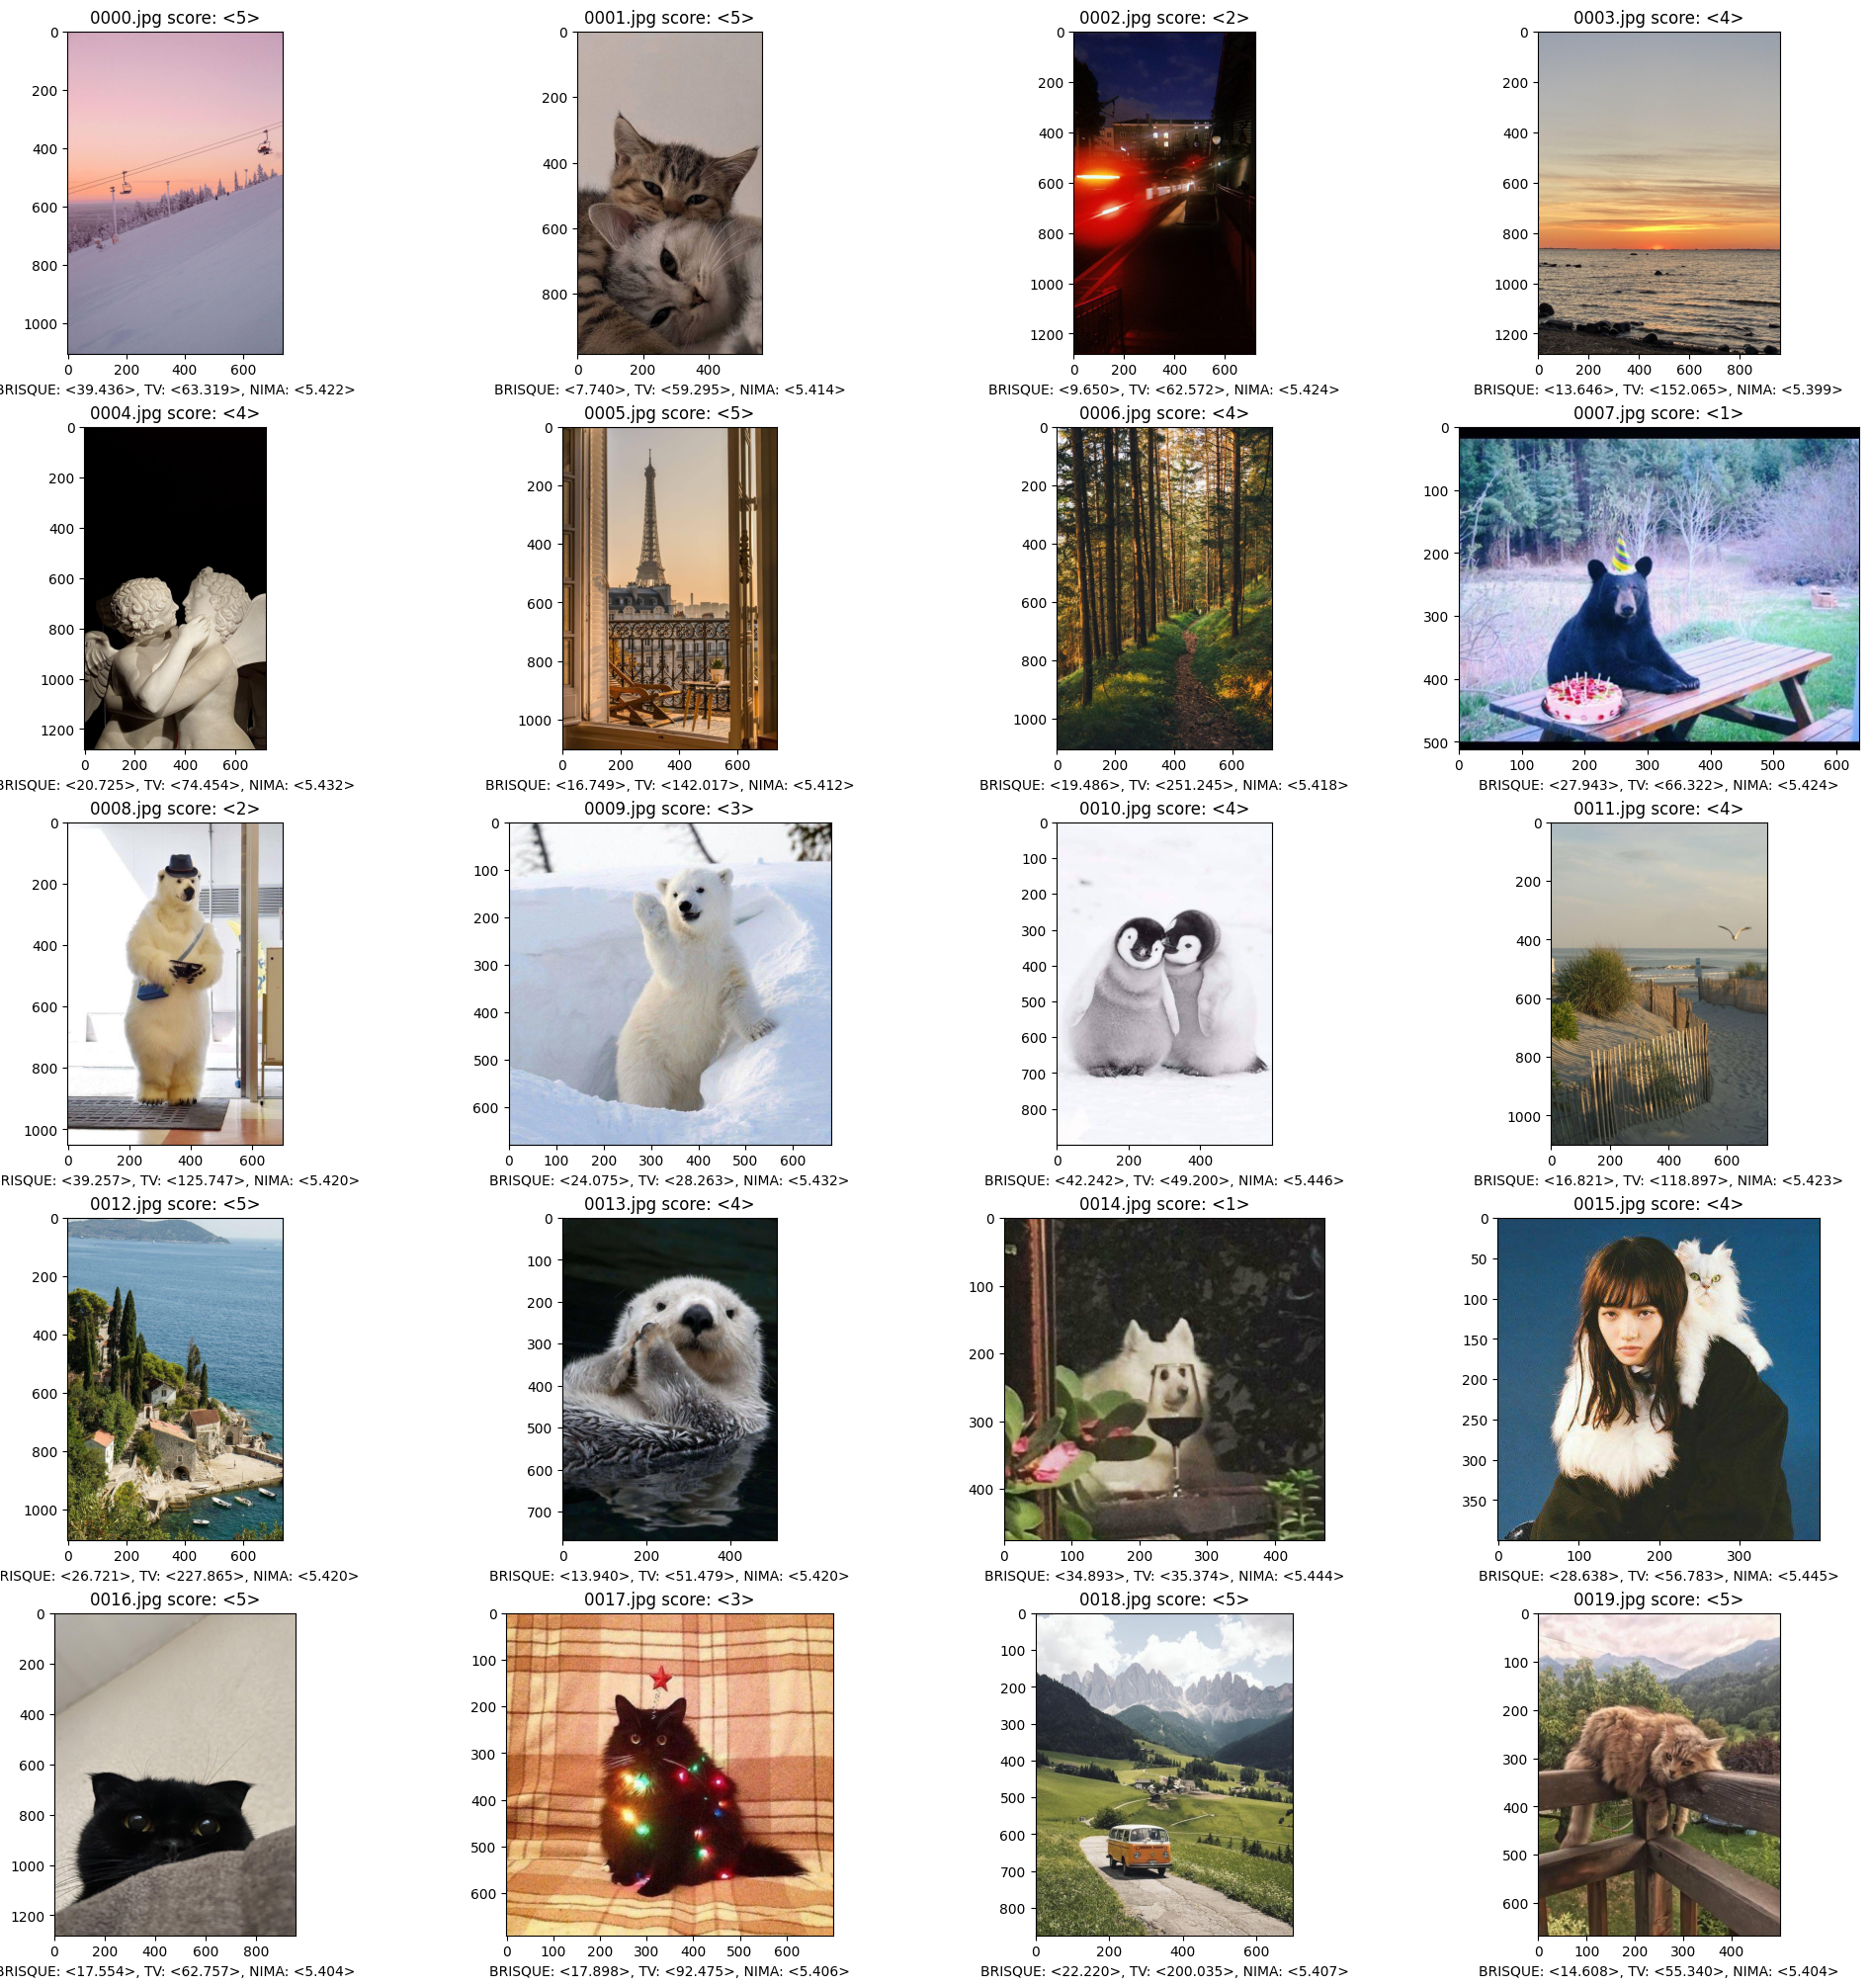

In [23]:
plot_images(scores_df, both_scores=True, brisque_lst=brisque_metrics,
            tv_lst=tv_metrics, nima_lst=nima_metrics)

### Best metric
Choose the best metric, which is more correlated with the human opinion.

In [36]:
# Calculate Pearson correlation coefficients
br_ho = stats.pearsonr(scores_df.score, scores_df.BRISQUE)[0]
tv_ho = stats.pearsonr(scores_df.score, scores_df.TV)[0]
nima_ho = stats.pearsonr(scores_df.score, scores_df.NIMA)[0]

In [37]:
table = BeautifulTable()
table.rows.append([br_ho, tv_ho, nima_ho])
table.rows.header = ["Pearson correlation coefficient"]
table.columns.header = ["BRISQUE", "TV", "NIMA"]
print(table)

+---------------------------------+---------+-------+--------+
|                                 | BRISQUE |  TV   |  NIMA  |
+---------------------------------+---------+-------+--------+
| Pearson correlation coefficient | -0.274  | 0.305 | -0.407 |
+---------------------------------+---------+-------+--------+


### Conclusion
From the Pearson correlation coefficient table, it can be concluded that the NIMA metric is more correlated with a human opinion. And interestingly, these two indicators have a negative correlation. This means that the higher the human opinion, the lower the NIMA metric will be.